In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils import data

FEAT_DIM = 38
INTER_DIM = 20
RES_DIM = 2
LR = 0.001
NB_EPOCH = 20
TEST_SPLIT = 20
VALID_SPLIT = 10

criterion = nn.MSELoss()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fcTop = nn.Linear(in_features=FEAT_DIM, out_features=INTER_DIM) 
        self.fcMid = nn.Linear(in_features=INTER_DIM, out_features=INTER_DIM)
        self.fcBot = nn.Linear(in_features=INTER_DIM, out_features=RES_DIM)
        
    def forward(self, x):
        x = F.relu(self.fcTop(x))
        for i in range(2):
            x = F.relu(self.fcMid(x))
        x = self.fcBot(x)
        x = F.softmax(x, dim=1)
        return x

    
class Dataset(data.Dataset):
  #Characterizes a dataset for PyTorch
    def __init__(self, list_IDs, labels, df):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.df = df

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index].item()
        # Load data and get label
        X = torch.Tensor(self.df.loc[ID].values)
        y = self.labels[ID]

        return X, y

    
def testTrainValidSplit(dataset, test_split=20, valid_split=10):
    
    def split(dt, percen):
        total_len = dt.size()[0]
        first_len = total_len*percen//100
        second_len = total_len-first_len
        second_idx = np.random.choice(total_len, second_len, replace=False)
        mask = np.ones(total_len)
        mask[second_idx] = 0
    
        second_set = dt[second_idx, :]
        first_set = dt[np.squeeze(np.argwhere(mask)),:]
        return first_set, second_set
    
    test_set, train_set = split(dataset, test_split)
    valid_set, train_set = split(train_set, valid_split)
    
    return test_set, train_set, valid_set

In [2]:
#------------------------Dataset preparation-------------------------
# Loading
df = pd.read_csv("league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv")
dataset = torch.tensor(df.values)

# Random train/test split
test_set, train_set, valid_set = testTrainValidSplit(dataset, test_split=TEST_SPLIT, valid_split=VALID_SPLIT)
train_target = train_set[:,1]
train_data_IDs = train_set[:,0]
test_target = test_set[:,1]
test_data_IDs = test_set[:,0]
valid_target = valid_set[:,1]
valid_data_IDs = valid_set[:,0]

# Datasets
partition = {}
partition['train'] = train_data_IDs
partition['valid'] = valid_data_IDs
partition['test'] = test_data_IDs

df = df.set_index(['gameId'])

# Mapping labels to approrpriate output form
dic = {0: (1,0), 1: (0,1)}
labels = df['blueWins'].map(dic).to_dict()

df = df.drop(columns=['blueWins'])

# Normalisation
df = (df-df.mean())/df.std()

# Generators
training_set = Dataset(partition['train'], labels, df)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['valid'], labels, df)
validation_generator = data.DataLoader(validation_set, **params)

test_set = Dataset(partition['test'], labels, df)
test_generator = data.DataLoader(test_set, **params)

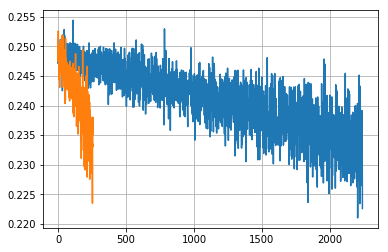

In [3]:
#------------------------Model preparation-------------------------
net = Net()
optimizer = optim.SGD(net.parameters(), lr=LR)

train_losses = []
valid_losses = []


# Loop over epochs
for epoch in range(NB_EPOCH):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_labels = torch.stack((local_labels[0], local_labels[1]), dim=1)
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        
        # Model computations
        optimizer.zero_grad()
        output = net(local_batch)
        loss = criterion(output, local_labels.to(dtype=torch.float))
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_labels = torch.stack((local_labels[0], local_labels[1]), dim=1)
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            output = net(local_batch)
            loss = criterion(output, local_labels.to(dtype=torch.float))
            valid_losses.append(loss)
            
            
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.grid()
plt.show()

In [4]:
# Testing

total_count = 0
correct_count = 0

with torch.set_grad_enabled(False):
        for local_batch, local_labels in test_generator:
            # Transfer to GPU
            local_labels = torch.stack((local_labels[0], local_labels[1]), dim=1)
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            output = net(local_batch)
            a = output.numpy()
            b = local_labels.numpy()
            a = np.argmax(a, axis=1)
            b = np.argmax(b, axis=1)
            c = a==b
            total_count = total_count + c.size
            correct_count = correct_count + np.sum(c)
            
print("Test Accuracy: {}".format(correct_count/total_count))

Test Accuracy: 0.7058227848101266


In [5]:
c.size

55